## Initialization

In [1]:
import numpy as np
import numba
import pandas as pd
import matplotlib.pyplot as plt
from reactionmodel.model import Species, Reaction, Model

In [2]:
R0 = 10.0
R0drug = 0.125
mu = 1.0
mdrug = 1.0
t_half = 1/24
y0 = 1000
ic50 = (R0/R0drug-1)**(-1*mdrug)

gamma = y0 * mu * (1 - R0drug)

@numba.jit(nopython=True)
def lambda_t(t):
    return R0 * mu / (1 + (1/ic50 * np.exp(-1 * np.log(2) * t / t_half))**mdrug)

In [3]:
ic50 * 6.05/1.0

0.07658227848101265

In [4]:
lambda_t(0.5)

9.810778443113772

Text(0.5, 0, 'time (average lifespans of infected cell)')

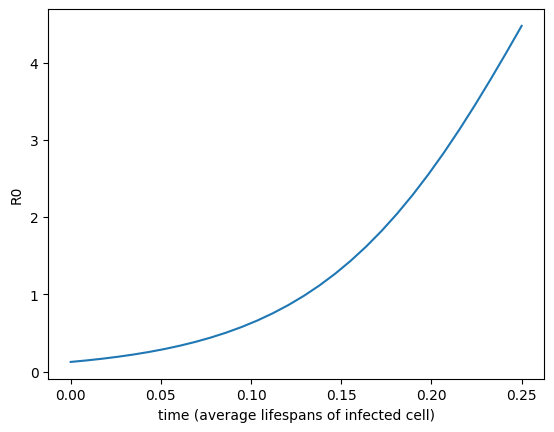

In [5]:
t_upper = t_half*6
t_eval = np.linspace(0.0, t_upper, 30)
R0s = [lambda_t(t)/mu for t in t_eval]

plt.plot(t_eval, R0s)
plt.ylabel('R0')
plt.xlabel('time (average lifespans of infected cell)')

In [6]:
t_span = [0.0, t_upper]
t_eval = np.linspace(t_span[0], t_span[-1], 30)

In [7]:
Y = Species('Y')

death = Reaction([Y], [], k=mu)
birth = Reaction([Y], [(Y, 2)], k=lambda_t)
generation = Reaction([], [Y], k=gamma)

m = Model([Y], [birth, death, generation])

ic = m.make_initial_condition({'Y':y0})

In [8]:
def make_df(results, t_eval):
    result_series = []

    for r in results:
        t, y = r.restricted_values(t_eval)
        result_series.append(pd.Series(y.T.squeeze(), index=t))
    
    df = pd.concat(result_series, axis=1)
    df = df.dropna()
    return df

## Gillespie

In [162]:
from hybrid.gillespie import GillespieSimulator

In [163]:
s = GillespieSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

In [88]:
results = s.run_simulations(
    1,
    [0.0, 4.0],
    ic,
    np.random.default_rng(),
    t_eval=t_eval,
)

In [91]:
gillespie_df = make_df(results, t_eval)

<Axes: >

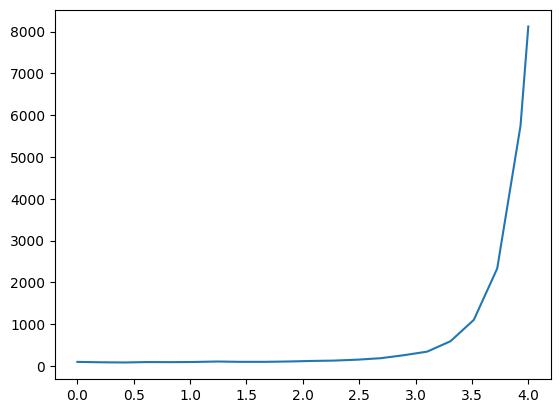

In [92]:
gillespie_df.mean(axis=1).plot()

## Homogeneous tau

In [9]:
from hybrid.tau import TauLeapSimulator

tau_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    #time_handling='inhomogeneous_monotonic'
)

In [10]:
results = tau_simulator.run_simulations(
    1000,
    t_span,
    ic,
    np.random.default_rng(),
    t_eval=t_eval,
)

In [11]:
results[0].status_counter

Counter({<TauStepStatus.leap: 2>: 29, <TauStepStatus.t_end: 0>: 1})

<Axes: >

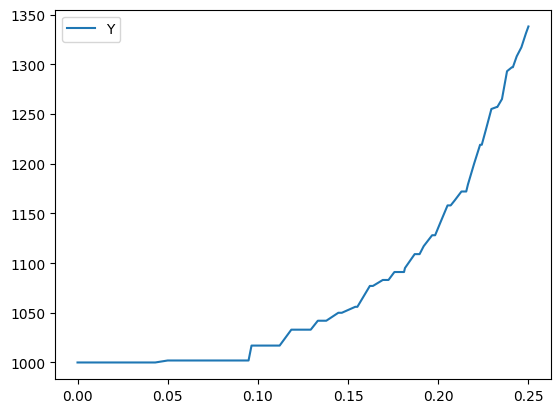

In [12]:
results[0].plot(m.legend())

In [15]:
tau_df = make_df(results, t_eval)
tau_df.index = tau_df.index.round(4)

## Inhomogeneous

In [20]:
from hybrid.tau import TauLeapSimulator

inhom_tau_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    time_handling='inhomogeneous_monotonic'
)

In [21]:
results = inhom_tau_simulator.run_simulations(
    100,
    t_span,
    ic,
    np.random.default_rng(),
    t_eval=t_eval
)

In [22]:
results[0].status_counter

Counter({<TauStepStatus.stochastic: 4>: 896,
         <TauStepStatus.rejected_for_gillespie: -2>: 9,
         <TauStepStatus.t_end: 0>: 1})

<Axes: >

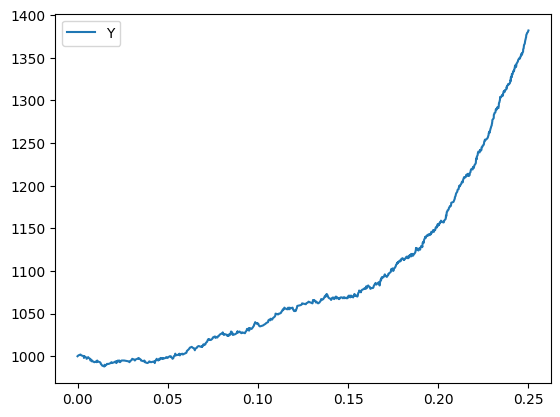

In [23]:
results[0].plot(m.legend())

In [30]:
inhom_tau_df = make_df(results, t_eval)
inhom_tau_df.index = inhom_tau_df.index.round(4)

## Deterministic

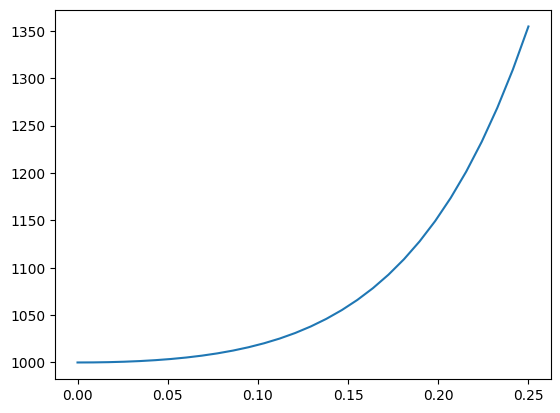

In [31]:
from scipy.integrate import solve_ivp
dydt = m.get_dydt(jit=True)

det_result = solve_ivp(dydt, t_span, ic, t_eval=t_eval, args=(0,))
det_result = pd.Series(det_result.y.T.squeeze(), index=det_result.t)

det_result.plot()
det_result.index = det_result.index.round(4)

In [32]:
inhom_tau_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0.0000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
0.0086,994.0,999.0,1002.0,997.0,1005.0,1000.0,1004.0,997.0,1001.0,1005.0,...,997.0,997.0,1000.0,1005.0,997.0,998.0,999.0,998.0,1007.0,1003.0
0.0259,995.0,1000.0,1000.0,1001.0,1005.0,1002.0,1008.0,1004.0,997.0,1011.0,...,1008.0,1005.0,1001.0,1001.0,988.0,997.0,999.0,993.0,994.0,1013.0
0.0345,997.0,1010.0,1007.0,999.0,1000.0,1004.0,1015.0,1013.0,998.0,1011.0,...,1016.0,1010.0,999.0,1002.0,988.0,994.0,995.0,993.0,996.0,1005.0
0.0431,994.0,1012.0,1007.0,1007.0,1001.0,1004.0,1018.0,1023.0,1001.0,1006.0,...,1012.0,1015.0,991.0,1001.0,974.0,992.0,998.0,987.0,1000.0,1010.0
0.0517,1000.0,1009.0,1009.0,1003.0,1004.0,1013.0,1022.0,1026.0,995.0,1006.0,...,1009.0,1018.0,990.0,1004.0,976.0,983.0,1002.0,986.0,998.0,1019.0
0.0603,1004.0,1009.0,1005.0,998.0,1002.0,1019.0,1030.0,1030.0,993.0,1012.0,...,1016.0,1020.0,993.0,1007.0,976.0,982.0,1011.0,984.0,1003.0,1026.0
0.0690,1011.0,1009.0,1010.0,1000.0,1009.0,1022.0,1034.0,1025.0,996.0,1014.0,...,1021.0,1027.0,991.0,1006.0,973.0,983.0,1009.0,986.0,1011.0,1023.0
0.0776,1022.0,1009.0,1017.0,1007.0,1004.0,1024.0,1037.0,1028.0,997.0,1018.0,...,1019.0,1024.0,993.0,1006.0,972.0,985.0,1005.0,997.0,1024.0,1026.0
0.0862,1025.0,1008.0,1019.0,1020.0,1009.0,1027.0,1038.0,1027.0,998.0,1023.0,...,1021.0,1033.0,990.0,1008.0,972.0,994.0,1004.0,1001.0,1024.0,1034.0


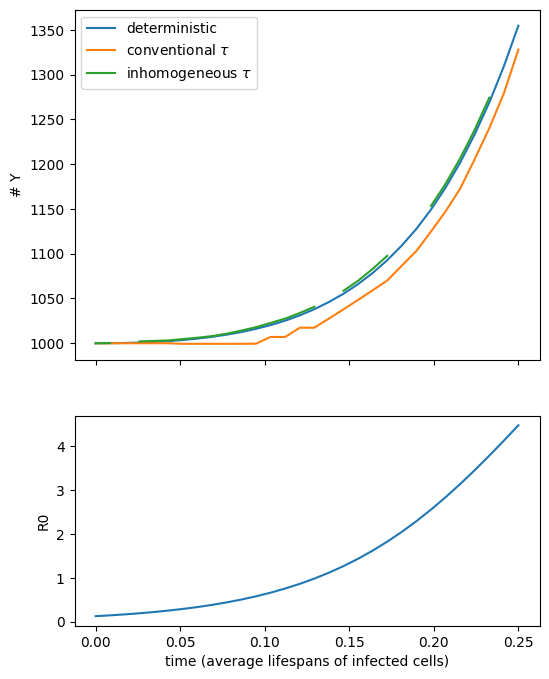

In [53]:
fig, ax = plt.subplots(2, height_ratios=[1.0, 0.6], figsize=(6,8), sharex=True)

data = {
    'deterministic': det_result,
    #'gillespie': gillespie_df.mean(axis=1),
    'conventional $\\tau$': tau_df.mean(axis=1),
    'inhomogeneous $\\tau$': inhom_tau_df.mean(axis=1),
}
combined = pd.DataFrame(data)
combined.plot(ax=ax[0])
#tau_df.mean(axis=1).plot(ax=ax)

ax[1].set_xlabel('time (average lifespans of infected cells)')
ax[0].set_ylabel('# Y')

R0s = [lambda_t(t)/mu for t in t_eval]

ax[1].plot(t_eval, R0s)
ax[1].set_ylabel('R0')

plt.savefig('./inhomogeneous.png', dpi=300)

Text(0.5, 0, 'time (average lifespans of infected cell)')

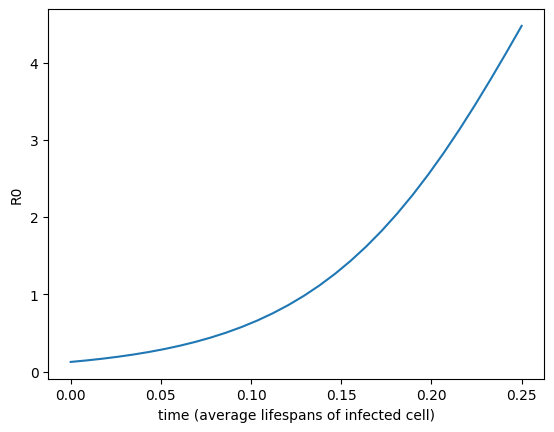

In [34]:
R0s = [lambda_t(t)/mu for t in t_eval]

plt.plot(t_eval, R0s)
plt.ylabel('R0')
plt.xlabel('time (average lifespans of infected cell)')

[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,

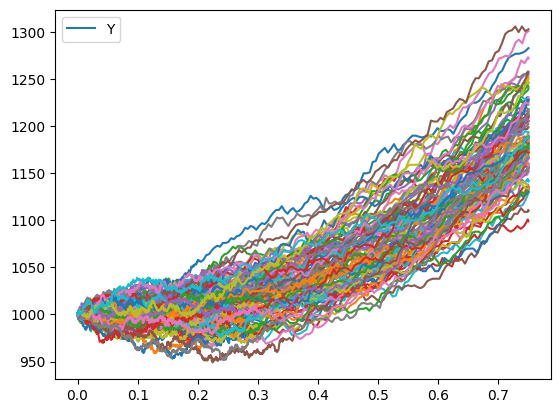

In [86]:
[r.plot(m.legend()) for r in result]